# Ejemplo de aplicacion - Markowitz

## Repaso básico

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

df = yf.download(['PYPL','AAPL'], start='2010-01-01', end='2021-01-01')['Adj Close']
df = df.loc[~(df==0).any(axis=1)] 
retornos = np.log((df/df.shift(1)).dropna())

[*********************100%***********************]  2 of 2 completed


In [2]:
datosTickers = []
for ticker in df.columns:
    d = {}
    d['ticker'] = ticker
    d['retorno'] = retornos[ticker].mean() * 252
    d['volatilidad'] = retornos[ticker].std() * (252**0.5)
    d['sharpe'] = d['retorno'] / d['volatilidad']
    datosTickers.append(d)
    

datosTickers = pd.DataFrame(datosTickers).set_index('ticker')
datosTickers

,retorno,volatilidad,sharpe
ticker,,,
AAPL,0.265538,0.302999,0.876365
PYPL,0.305063,0.342400,0.890955


In [3]:
q = 500
retornos = np.log((df/df.shift(1)).dropna())
carteras = [] 

for i in range(q):
    pond = np.array(np.random.random(len(df.columns)))
    pond = pond/np.sum(pond)
    r={}
    r['retorno'] = np.sum( (retornos.mean() * pond * 252))
    r['volatilidad'] = np.sqrt(np.dot(pond, np.dot(retornos.cov()*252, pond)))
    r['sharpe'] = r['retorno'] / r['volatilidad'] 
    r['pesos'] = pond.round(4)
    carteras.append(r)

carteras = pd.DataFrame(carteras)
carteras

,retorno,volatilidad,sharpe,pesos
0,0.288902,0.293553,0.984156,"[0.4089, 0.5911]"
1,0.289660,0.294943,0.982088,"[0.3897, 0.6103]"
2,0.288580,0.292994,0.984937,"[0.417, 0.583]"
3,0.274199,0.287662,0.953196,"[0.7809, 0.2191]"
4,0.282818,0.286158,0.988329,"[0.5628, 0.4372]"
...,...,...,...,...
495,0.300247,0.324023,0.926623,"[0.1218, 0.8782]"
496,0.281081,0.285317,0.985152,"[0.6068, 0.3932]"
497,0.285027,0.288052,0.989496,"[0.5069, 0.4931]"
498,0.270141,0.293208,0.921329,"[0.8835, 0.1165]"


In [4]:
carteras.sharpe.max()

0.9895234808702917

In [5]:
carteras.sharpe.idxmax()

33

In [6]:
carteras.loc[ carteras.sharpe.idxmax(), 'pesos']

array([0.5147, 0.4853])

In [7]:
optimo = carteras.loc[carteras.sharpe.idxmax()]
mejor_port = carteras.iloc[carteras.sharpe.idxmax()]['pesos']

datosTickers['ponderacion_optima'] = mejor_port
datosTickers

,retorno,volatilidad,sharpe,ponderacion_optima
ticker,,,,
AAPL,0.265538,0.302999,0.876365,0.5147
PYPL,0.305063,0.342400,0.890955,0.4853


In [8]:
optimo

retorno                0.284721
volatilidad            0.287735
sharpe                 0.989523
pesos          [0.5147, 0.4853]
Name: 33, dtype: object

In [9]:
mejor_port

array([0.5147, 0.4853])

In [10]:
datosTickers

,retorno,volatilidad,sharpe,ponderacion_optima
ticker,,,,
AAPL,0.265538,0.302999,0.876365,0.5147
PYPL,0.305063,0.342400,0.890955,0.4853


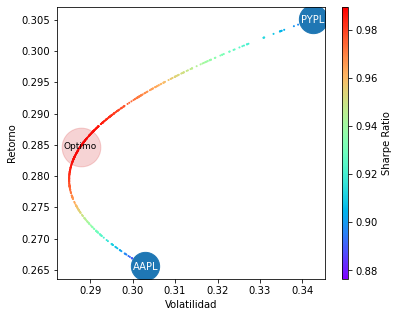

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.scatter(carteras.volatilidad, carteras.retorno, c=carteras.sharpe, s=1, cmap='rainbow')

plt.colorbar(label='Sharpe Ratio', aspect=40)
plt.xlabel('Volatilidad')
plt.ylabel('Retorno')

plt.scatter(optimo.volatilidad, optimo.retorno,c='tab:red', alpha=0.2, s=1500) 
plt.text(optimo.volatilidad, optimo.retorno, 'Optimo', fontsize=9, c='k', ha='center', va='center') 

for ticker in df.columns:
    vol = datosTickers.loc[ticker,'volatilidad'] 
    ret = datosTickers.loc[ticker,'retorno'] 
    plt.scatter(vol, ret,  c='tab:blue', s=800) 
    plt.text(vol, ret, ticker, c='w', ha='center', va='center') 

## Markowitz - 500 activos

Buscamos el portafolio optimo entre muchos portafolios posibles

### Bajamos Data

In [12]:
import yfinance as yf, numpy as np, pandas as pd, random, tqdm


# Obtengo el listado de tickers del sp500
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_tickers = list(sp500.Symbol)
sp500_tickers = [e for e in sp500_tickers if e not in ('BRK.B','BF.B')]

sp500_tickers[:10]

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES']

In [14]:
import yfinance as yf, numpy as np, pandas as pd, random, tqdm
pd.options.display.max_columns = 8

In [16]:
%%time

# Obtengo todos los historicos
data_sp500 = yf.download(sp500_tickers, start='2018-01-01', end='2021-01-01')['Adj Close']

# Para evitar tickers con poco historial
conteo = pd.DataFrame(data_sp500.count(), columns=['Q'])
sp500_tickers = list(conteo.loc[conteo.Q>500].index)

data_sp500

[*********************100%***********************]  503 of 503 completed
Wall time: 39.5 s


,A,AAL,AAP,AAPL,...,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,
2018-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
2018-01-02,65.985886,51.647556,104.916702,41.105534,...,121.328224,103.709999,46.599628,70.489136
2018-01-03,67.664825,51.014027,105.866096,41.098373,...,122.169281,105.769997,46.544483,70.813225
2018-01-04,67.157242,51.335667,109.772415,41.289268,...,121.993256,107.860001,46.737503,71.235565
2018-01-05,68.230972,51.316177,110.939346,41.759361,...,123.205963,109.540001,46.755882,72.050766
...,...,...,...,...,...,...,...,...,...
2020-11-09,112.500000,13.200000,156.630005,116.320000,...,155.949997,352.709991,39.240002,165.199997
2020-11-10,110.199997,12.380000,155.419998,115.970001,...,150.160004,345.019989,38.980000,162.559998
2020-11-11,109.410004,12.040000,156.520004,119.489998,...,149.399994,356.269989,37.240002,164.949997


### Dirichlet vs Uniform

Muestra de ponderaciones que sumen 1, con restricciones (min y max)

https://en.wikipedia.org/wiki/Dirichlet_distribution

In [17]:
np.random.dirichlet(np.ones(5),1)

array([[0.50995336, 0.24499405, 0.06405082, 0.108023  , 0.07297877]])

In [18]:
p_min, p_max =0.05, 0.5
n_stocks = 5

ponds = np.random.dirichlet(np.ones(n_stocks),100)
oks = [p for p in ponds if (p.min()>p_min) & (p.max()<p_max)]
oks[0]

array([0.09210243, 0.10442617, 0.13760812, 0.25008999, 0.41577329])

In [19]:
media = (p_min+p_max)/2

pond = np.random.uniform(p_min*media*n_stocks, p_max*media*n_stocks, n_stocks)
pond = pond / np.sum(pond)
pond.round(4)*100

array([26.14,  8.35, 21.23, 19.04, 25.24])

### Funcion optimizadora

In [20]:
import sys

def simular(data, tickers, q, n_stocks=3, p_min=0.1, p_max=0.6):
    
    datos = []
    with tqdm.tqdm(total=q, file=sys.stdout) as pbar:
        for i in range(q):
            pbar.update()

            muestra = data[random.sample(tickers, n_stocks)]
                        
            # Restriccion de minimo
            ponds = np.random.dirichlet(np.ones(n_stocks),50)
            pond = np.array([p for p in ponds if (p.min()>p_min) & (p.max()<p_max)][0])
            
            # If para evitar activos sin dataFeed
            if len(retornos):    
                r={}
                r['activos'] = list(muestra.columns)
                r['pesos'] = pond.round(3)
                r['retorno'] = np.sum( (muestra.mean() * pond * 252))
                r['volatilidad'] = np.sqrt(np.dot(pond, np.dot(muestra.cov()*252, pond)))
                r['sharpe'] = round(r['retorno'] / r['volatilidad'],3) 
                datos.append(r)
    
    df = pd.DataFrame(datos).sort_values('sharpe', ascending=False)

    return df

In [21]:
pd.options.display.width = 1000

ret_log = np.log(data_sp500/data_sp500.shift(1))

portfolios = simular(ret_log, sp500_tickers, 20000,3)
print('\n',portfolios.head(10))

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:26<00:00, 759.68it/s]

                  activos                  pesos   retorno  volatilidad  sharpe
10539   [ADBE, CMG, WST]  [0.192, 0.505, 0.303]  0.434789     0.296961   1.464
4763   [DXCM, DHR, LRCX]   [0.416, 0.45, 0.134]  0.446120     0.315083   1.416
8066    [KEYS, TGT, WST]  [0.422, 0.236, 0.342]  0.359204     0.266093   1.350
1060    [CMG, POOL, HCA]   [0.428, 0.442, 0.13]  0.396767     0.294356   1.348
4324    [XEL, CPRT, CMG]  [0.424, 0.127, 0.449]  0.346803     0.260553   1.331
2927    [MSCI, PAYC, DG]    [0.491, 0.18, 0.33]  0.389810     0.294054   1.326
3856   [GRMN, WST, FTNT]    [0.244, 0.6, 0.157]  0.345667     0.260849   1.325
17445    [NEM, DG, MSCI]  [0.215, 0.308, 0.477]  0.329605     0.250370   1.316
8190    [ETN, DXCM, DPZ]   [0.401, 0.43, 0.169]  0.447557     0.340818   1.313
11210   [DXCM, PG, ORLY]  [0.511, 0.283, 0.206]  0.411084     0.315359   1.304


In [22]:
top = portfolios.iloc[ : 100]
lista_tickers = list(top.activos.apply(pd.Series).stack())
len(lista_tickers)

300

In [23]:
np.unique(lista_tickers, return_counts=True)

(array(['AAPL', 'ACN', 'ADBE', 'ADM', 'ADSK', 'AEE', 'AIZ', 'AJG', 'AMD',
        'AME', 'AMT', 'AMZN', 'AON', 'ATO', 'AZO', 'BIO', 'BLL', 'BMY',
        'CCI', 'CHD', 'CHTR', 'CLX', 'CMG', 'CMS', 'COST', 'CPB', 'CPRT',
        'CTAS', 'DD', 'DG', 'DHR', 'DPZ', 'DXCM', 'EA', 'ECL', 'EL', 'EQR',
        'ES', 'ETN', 'ETSY', 'EW', 'FRC', 'FTNT', 'GM', 'GRMN', 'GWW',
        'HCA', 'HD', 'HRL', 'HWM', 'ICE', 'IDXX', 'IR', 'IRM', 'JBHT',
        'KEYS', 'KMI', 'KO', 'KSU', 'LHX', 'LIN', 'LRCX', 'LYB', 'MA',
        'MAR', 'MDLZ', 'MDT', 'MKC', 'MKTX', 'MNST', 'MSCI', 'MSFT', 'MTB',
        'MTD', 'NEM', 'NFLX', 'NKE', 'NOW', 'NSC', 'NUE', 'NVDA', 'OMC',
        'ORLY', 'PAYC', 'PEAK', 'PG', 'PGR', 'PKI', 'PLD', 'POOL', 'PWR',
        'PYPL', 'QCOM', 'RMD', 'ROL', 'SBAC', 'SBUX', 'SHW', 'SIVB', 'SJM',
        'SNPS', 'SO', 'STE', 'TER', 'TFX', 'TGT', 'TMO', 'TMUS', 'TT',
        'TYL', 'UPS', 'VAR', 'VRSK', 'VRSN', 'WFC', 'WHR', 'WLTW', 'WMT',
        'WST', 'XEL', 'ZBRA', 'ZTS'], dtype='<U

In [24]:
freq = pd.DataFrame(np.unique(lista_tickers, return_counts=True)).T
freq.columns=['Ticker','Frecuencia']
freq.sort_values('Frecuencia', ascending=False)

,Ticker,Frecuencia
32,DXCM,22
22,CMG,15
8,AMD,11
16,BLL,9
39,ETSY,9
...,...,...
54,JBHT,1
53,IRM,1
52,IR,1
50,ICE,1


## Markowitz - Optimizacion de suboptimo

Optimmizamos las iteraciones para encontrar un sub-optimo mas rapido

In [25]:
%%time
q_inicial = 800
lista_tickers = sp500_tickers
ret_log = np.log(data_sp500/data_sp500.shift(1))

portfolios = simular(ret_log, lista_tickers, q_inicial, n_stocks=3, p_min=0.01, p_max=0.99)

best = pd.DataFrame()
for i in range(8):
    top = portfolios.iloc[ : int(200/(i+1))]
    lista_tickers = list(np.array(top.activos.apply(pd.Series).stack()))
    portfolios = simular(ret_log, lista_tickers, int(q_inicial/(i+2)))
    best = pd.concat([best,portfolios.iloc[:10]])

print('Mejores\n',best.sort_values('sharpe', ascending=False).head(10))

100%|█████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 766.26it/s]
Mejores
              activos                  pesos   retorno  volatilidad  sharpe
28  [DXCM, WST, CMG]  [0.273, 0.466, 0.261]  0.476167     0.291677   1.633
30  [CMG, DXCM, WST]     [0.38, 0.13, 0.49]  0.458434     0.281034   1.631
16  [CMG, DXCM, WST]   [0.34, 0.295, 0.365]  0.490997     0.301360   1.629
92  [CMG, DXCM, WST]  [0.295, 0.139, 0.566]  0.449964     0.276486   1.627
2   [DXCM, WST, CMG]  [0.293, 0.472, 0.235]  0.477580     0.294274   1.623
7     [CMG, DG, WST]  [0.249, 0.447, 0.304]  0.370863     0.229463   1.616
20   [DHR, WST, CMG]  [0.358, 0.336, 0.306]  0.402955     0.249523   1.615
68   [DHR, CMG, WST]  [0.349, 0.319, 0.332]  0.405040     0.250892   1.614
0   [CMG, DXCM, WST]  [0.345, 0.333, 0.322]  0.500245     0.310005   1.614
6    [DHR, WST, CMG]  [0.377, 0.365, 0.258]  0.396042     0.245818   1.611
Wall time: 3.13 s


## Rolling trimestral del proceso

### Bajamos Data mas antigua

In [26]:
pd.options.display.max_columns = 6

In [28]:
%%time

data_sp500 = yf.download(sp500_tickers, start='2000-01-01', end='2021-01-01')['Adj Close']
data_sp500

[*********************100%***********************]  494 of 494 completed
Wall time: 1min 11s


,A,AAL,AAP,...,ZBRA,ZION,ZTS
Date,,,,,,,
1999-12-31,NaN,NaN,NaN,...,NaN,NaN,NaN
2000-01-03,44.603386,NaN,NaN,...,25.027779,39.996193,NaN
2000-01-04,41.196171,NaN,NaN,...,24.666666,38.059437,NaN
2000-01-05,38.640766,NaN,NaN,...,25.138889,38.014412,NaN
2000-01-06,37.169479,NaN,NaN,...,23.777779,38.554890,NaN
...,...,...,...,...,...,...,...
2020-11-09,112.500000,13.20,156.630005,...,352.709991,39.240002,165.199997
2020-11-10,110.199997,12.38,155.419998,...,345.019989,38.980000,162.559998
2020-11-11,109.410004,12.04,156.520004,...,356.269989,37.240002,164.949997


### Guardamos la data 

In [29]:
import pickle

In [30]:
with open('data/portafolio/yahoo_sp500_10yr.dat', 'wb') as file:
    pickle.dump(data_sp500, file)

In [31]:
with open('data/portafolio/yahoo_sp500_10yr.dat', 'rb') as file:
    data_sp500 = pickle.load(file)

In [32]:
pd.options.display.max_columns = 6
data_sp500

,A,AAL,AAP,...,ZBRA,ZION,ZTS
Date,,,,,,,
1999-12-31,NaN,NaN,NaN,...,NaN,NaN,NaN
2000-01-03,44.603386,NaN,NaN,...,25.027779,39.996193,NaN
2000-01-04,41.196171,NaN,NaN,...,24.666666,38.059437,NaN
2000-01-05,38.640766,NaN,NaN,...,25.138889,38.014412,NaN
2000-01-06,37.169479,NaN,NaN,...,23.777779,38.554890,NaN
...,...,...,...,...,...,...,...
2020-11-09,112.500000,13.20,156.630005,...,352.709991,39.240002,165.199997
2020-11-10,110.199997,12.38,155.419998,...,345.019989,38.980000,162.559998
2020-11-11,109.410004,12.04,156.520004,...,356.269989,37.240002,164.949997


### Fragmentamos la data

In [33]:
trimestres = pd.date_range(start='1/1/2000', end='31/12/2020', freq='Q')
trimestres

DatetimeIndex(['2000-03-31', '2000-06-30', '2000-09-30', '2000-12-31', '2001-03-31', '2001-06-30', '2001-09-30', '2001-12-31', '2002-03-31', '2002-06-30', '2002-09-30', '2002-12-31', '2003-03-31', '2003-06-30', '2003-09-30', '2003-12-31', '2004-03-31', '2004-06-30', '2004-09-30', '2004-12-31', '2005-03-31', '2005-06-30', '2005-09-30', '2005-12-31', '2006-03-31', '2006-06-30', '2006-09-30', '2006-12-31', '2007-03-31', '2007-06-30', '2007-09-30', '2007-12-31', '2008-03-31', '2008-06-30', '2008-09-30', '2008-12-31', '2009-03-31', '2009-06-30', '2009-09-30', '2009-12-31', '2010-03-31', '2010-06-30', '2010-09-30', '2010-12-31', '2011-03-31', '2011-06-30', '2011-09-30', '2011-12-31', '2012-03-31', '2012-06-30', '2012-09-30', '2012-12-31', '2013-03-31', '2013-06-30', '2013-09-30', '2013-12-31', '2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31', '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31', '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31', '2017-03-31', '2017-06-30',
     

In [34]:
trimestres_from = list(trimestres[:-1])
trimestres_to = list(trimestres[1:])

In [35]:
dfs = []
rets_log = np.log(data_sp500/data_sp500.shift(1))
for i in range (len(trimestres_from)):
    df = rets_log.loc[(rets_log.index >= trimestres_from[i]) & (rets_log.index <= trimestres_to[i])].copy()
    df.dropna(axis=1, thresh=30, inplace=True)
    dfs.append(df)

In [36]:
len(dfs)

83

### Encapsulamos implementacion para optimizar

In [37]:
def top10(ret_log, lista_tickers, q_inicial=1000, rondas=10, n_inicial=6):
    portfolios = simular(ret_log, lista_tickers, q_inicial, n_stocks=n_inicial, p_min=0.01, p_max=0.99)
    best = pd.DataFrame()
    for i in range(rondas):
        top = portfolios.iloc[ : int(200/(i+1))]
        lista_tickers = list(np.array(top.activos.apply(pd.Series).stack()))
        portfolios = simular(ret_log, lista_tickers, int(q_inicial/(i+2)))
        best = pd.concat([best,portfolios.iloc[:10]])

    top10 = best.sort_values('sharpe', ascending=False).head(10)
    return top10

### Corremos optimizacion rollenado trimestralmente

In [38]:
from IPython.display import clear_output

In [39]:
%%time

tops = []
for i, df in enumerate(dfs):
    clear_output(wait=True)
    print('Proceso N°',i,'de',len(dfs))
    print('Desde',trimestres_from[i],'Hasta',trimestres_to[i],'\n')
    top = top10(df, list(df.columns), q_inicial=800, rondas=5)
    tops.append(top) 

Proceso N° 82 de 83
Desde 2020-09-30 00:00:00 Hasta 2020-12-31 00:00:00 

100%|███████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 615.74it/s]
Wall time: 3min 55s


In [40]:
activos, pesos = [], []
for i in range(10):
    activos.append([df.iloc[i].activos for df in tops])
    pesos.append([df.iloc[i].pesos for df in tops])

In [41]:
resumen = pd.DataFrame()

for top_nro in range(10):
    lista_rendimientos = []
    for i in range(1,len(dfs)):
        filtro_fecha = data_sp500.loc[(data_sp500.index >= trimestres_from[i]) & (data_sp500.index <= trimestres_to[i])]
        filtro_activos = filtro_fecha[activos[top_nro][i-1]].dropna()
        r = filtro_activos.pct_change()
        w = pesos[top_nro][i-1]
        fechas = pd.to_datetime(filtro_activos.index)
        lista_rendimientos.append(pd.Series(np.dot(r, w), index=fechas).dropna())

    rendimientos = pd.concat(lista_rendimientos)
    resumen['Test_'+str(top_nro)] = (rendimientos+1).cumprod()

resumen

,Test_0,Test_1,Test_2,...,Test_7,Test_8,Test_9
Date,,,,,,,
2000-07-03,1.008037,1.001797,0.987279,...,1.007036,0.997694,0.999480
2000-07-05,1.014594,1.018513,0.989737,...,1.014198,1.039166,1.012281
2000-07-06,1.023536,1.011990,1.002989,...,1.033110,1.039067,1.067742
2000-07-07,1.016594,1.007826,0.991746,...,1.027786,1.035998,1.073673
2000-07-10,1.013910,1.006916,0.979373,...,1.009965,1.057460,1.077166
...,...,...,...,...,...,...,...
2020-11-09,52.182696,35.084246,56.093449,...,53.997304,64.596589,39.827386
2020-11-10,52.752025,35.390571,56.529981,...,53.416302,64.956243,40.477288
2020-11-11,52.870551,35.615865,57.020992,...,54.563924,64.867015,40.187649


### Guardamos resultados estrategia

In [69]:
with open('data/portafolio/resumen.dat', 'wb') as file:
    pickle.dump(resumen, file)

with open('data/portafolio/resumen.dat', 'rb') as file:
    resumen = pickle.load(file)

### Ploteamos

<AxesSubplot:xlabel='Date'>

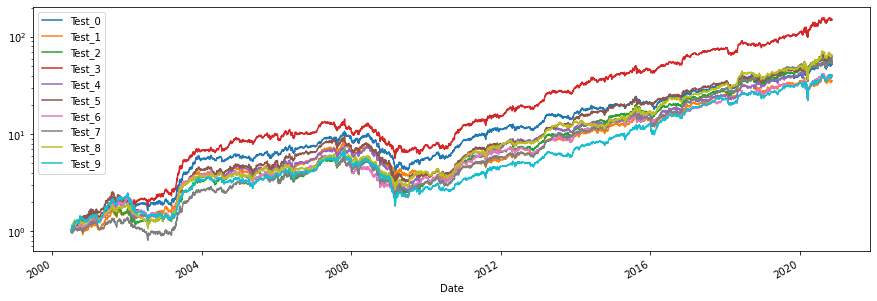

In [43]:
resumen.plot(figsize=(15,5), logy=True)

In [44]:
inicio = list(resumen.index)[0].isoformat()[:10]
inicio

'2000-07-03'

In [45]:
spy = yf.download('SPY', start=inicio, auto_adjust=True)
spy['pctChange'] = spy.Close.pct_change()
spy['rendimiento_acum'] = (spy.pctChange+1).cumprod()

[*********************100%***********************]  1 of 1 completed


[]

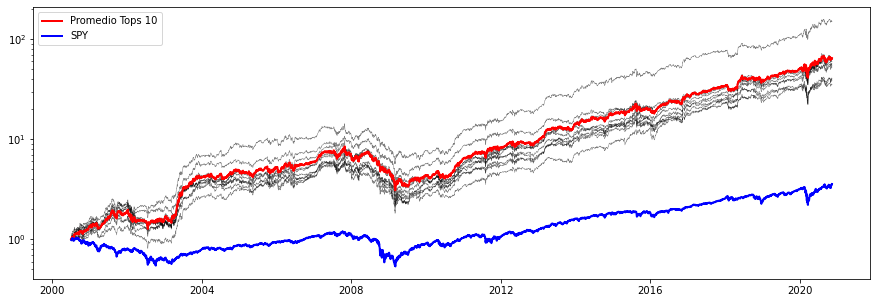

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5))

for columna in resumen.columns:
    ax.plot(resumen[columna], 'k', alpha=0.5, lw=0.5)
    ax.set_yscale('log')

ax.plot(resumen.iloc[:,:-1].mean(axis=1), 'red', lw=2, label='Promedio Tops 10')
ax.plot(spy['rendimiento_acum'], 'blue', lw=2, label='SPY')

ax.legend()
ax.plot()

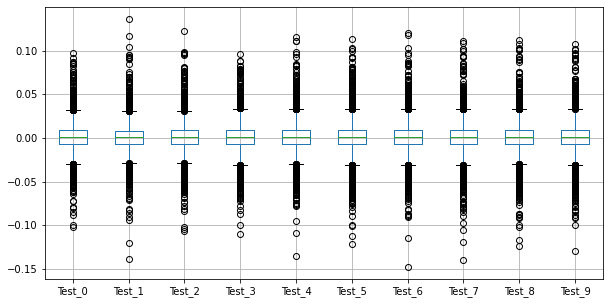

In [47]:
pd.plotting.boxplot_frame(resumen.pct_change(), figsize=(10,5))
plt.show()

## Reporting Final

In [48]:
estrategia = resumen.iloc[:,:-1].mean(axis=1)

# Armo estrategia mas conservadora
free_risk = pd.DataFrame(index=estrategia.index)
free_risk['usa'] = 0.0001
estrategia_5050 = estrategia.pct_change()*0.5 + free_risk['usa']*0.5

# Defino un benchMark
benchmark = spy['rendimiento_acum']

In [49]:
# !pip install QuantStats
import quantstats as qs
qs.extend_pandas()

In [50]:
qs.stats.outliers(estrategia.pct_change()-benchmark.pct_change(), quantile=0.995)

Date
2000-12-20    0.050005
2001-08-03    0.055292
2001-09-17    0.056708
2002-01-24    0.043607
2002-02-11    0.047442
2002-12-05    0.052800
2003-04-02    0.047914
2003-04-24    0.048785
2003-05-05    0.056070
2003-05-09    0.059758
2003-05-27    0.051611
2003-06-16    0.052989
2008-10-15    0.068068
2008-11-19    0.045808
2009-04-27    0.052440
2009-07-23    0.043698
2011-08-10    0.044838
2012-04-26    0.048842
2015-07-16    0.055900
2016-11-11    0.086523
2018-05-03    0.080841
2020-03-04    0.053439
2020-04-01    0.045532
2020-05-28    0.049282
2020-05-29    0.065830
2020-06-19    0.045863
dtype: float64

In [51]:
qs.stats.monthly_returns(estrategia)

,JAN,FEB,MAR,...,NOV,DEC,EOY
2000,0.000000,0.000000,0.000000,...,0.042506,0.100613,0.306179
2001,0.060759,-0.010829,-0.082545,...,-0.005224,0.038360,0.349462
2002,-0.041945,-0.163970,0.017126,...,-0.016808,-0.004977,-0.152336
2003,0.061960,-0.046582,0.062810,...,0.066114,-0.020071,1.052390
2004,-0.000206,0.040107,0.031651,...,0.087273,-0.019526,0.175180
2005,-0.057103,0.004961,-0.016506,...,0.010606,0.082164,0.062875
2006,-0.067579,0.083643,0.112117,...,0.043140,0.012515,0.176052
2007,0.035243,0.099398,0.074261,...,-0.094542,-0.035783,0.177694
2008,-0.085922,0.011068,0.034431,...,-0.034116,-0.042610,-0.288717
2009,-0.145296,-0.144101,0.038717,...,0.062198,0.074130,-0.060265


In [52]:
qs.reports.metrics(estrategia, benchmark, mode='full')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2000-07-03  2000-07-03
End Period                 2020-11-13  2020-11-13
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          6,300.49%   263.57%
CAGR%                      22.64%      6.54%
Sharpe                     0.97        0.42
Sortino                    1.42        0.59
Max Drawdown               -63.62%     -55.19%
Longest DD Days            1493        2241
Volatility (ann.)          24.26%      19.8%
R^2                        0.4         0.4
Calmar                     0.36        0.12
Skew                       0.01        -0.03
Kurtosis                   5.46        12.77

Expected Daily %           0.08%       0.03%
Expected Monthly %         1.71%       0.53%
Expected Yearly %          21.9%       6.34%
Kelly Criterion            6.56%       0.3%
Risk of Ruin               0.0%     

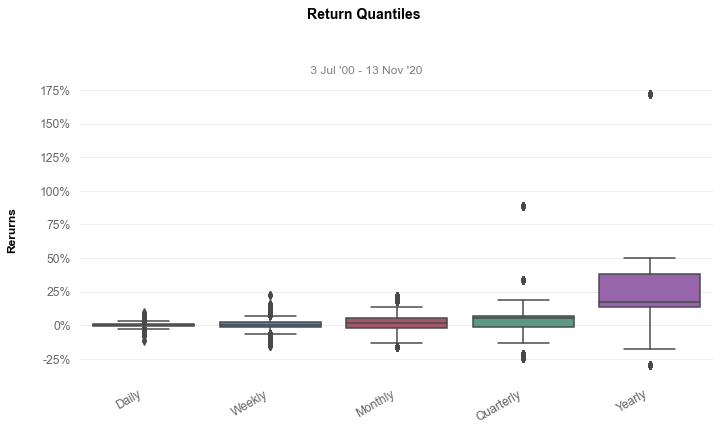

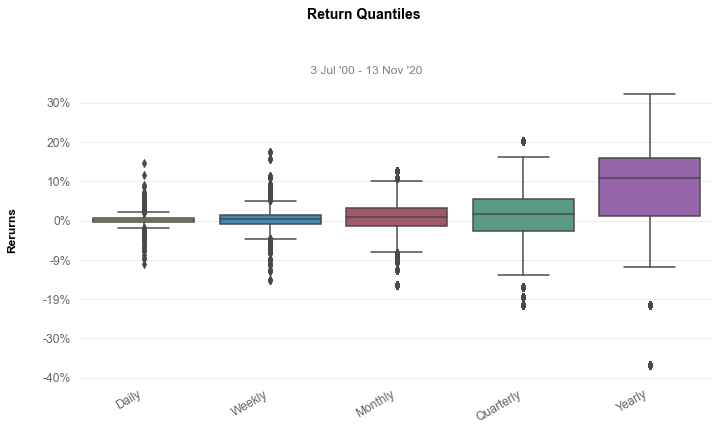

In [53]:
qs.plots.distribution(estrategia)
qs.plots.distribution(benchmark)

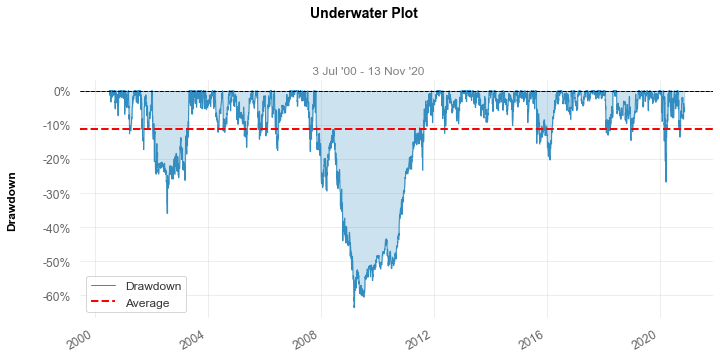

In [54]:
qs.plots.drawdown(estrategia)

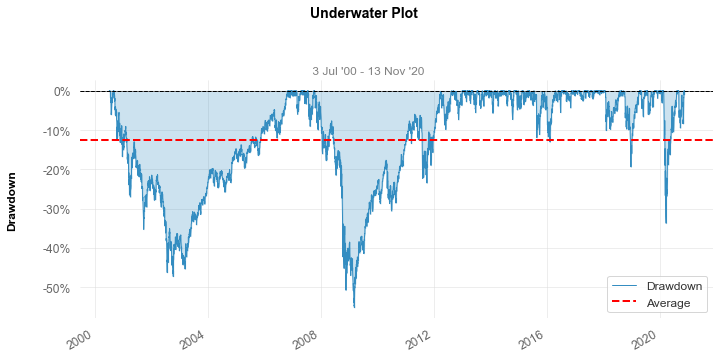

In [58]:
qs.plots.drawdown(benchmark)

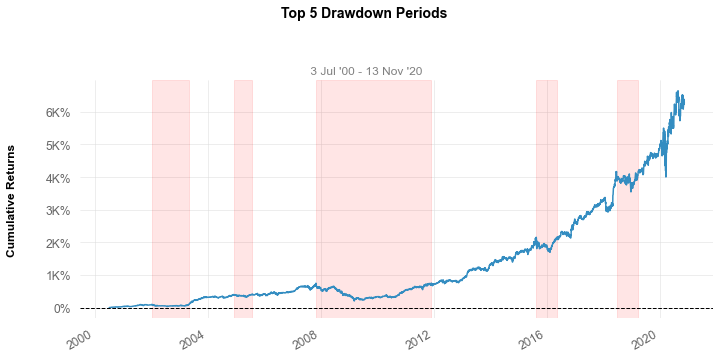

In [56]:
qs.plots.drawdowns_periods(estrategia)

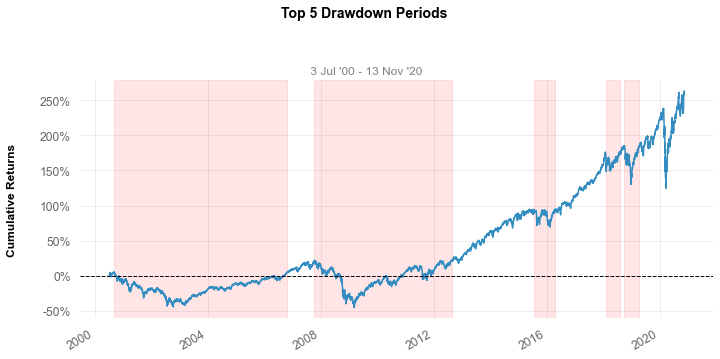

In [57]:
qs.plots.drawdowns_periods(benchmark)

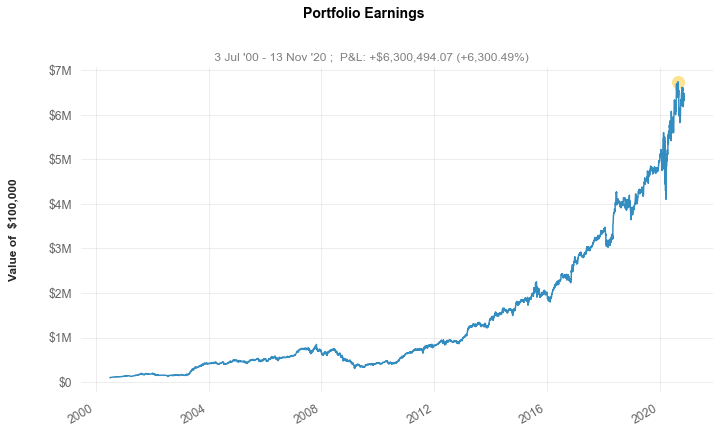

In [59]:
qs.plots.earnings(estrategia)

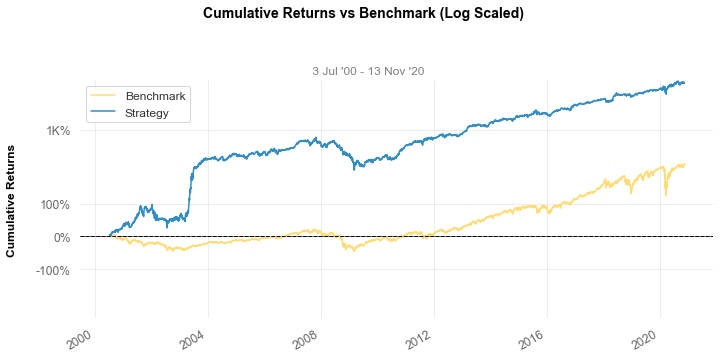

In [60]:
qs.plots.log_returns(estrategia, benchmark)

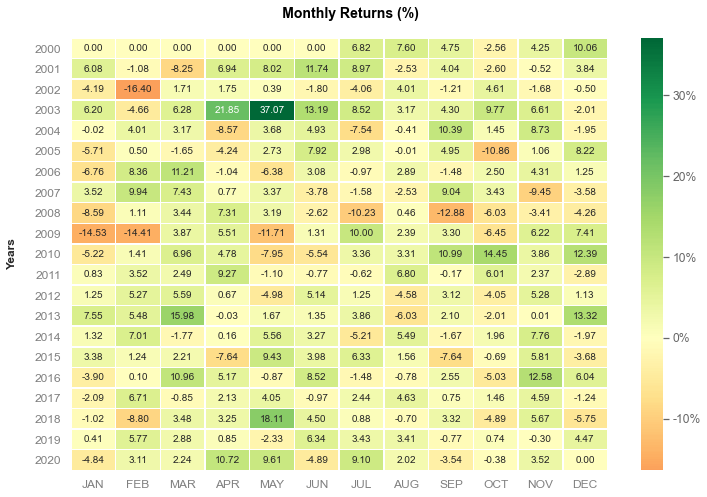

In [61]:
qs.plots.monthly_returns(estrategia, eoy=False)

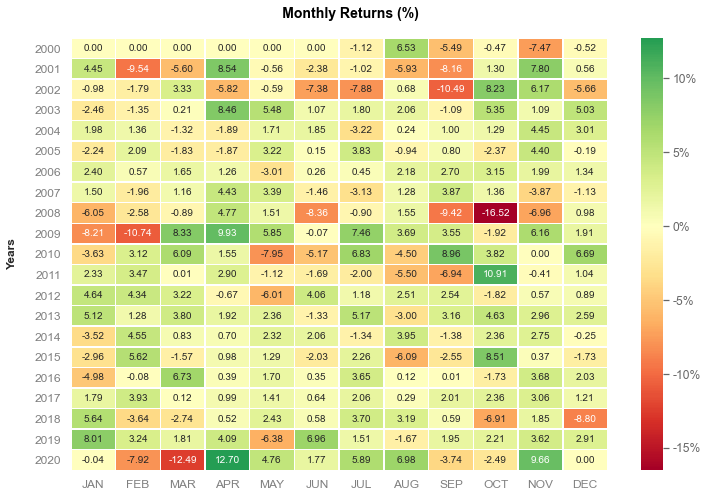

In [62]:
qs.plots.monthly_returns(benchmark, eoy=False)

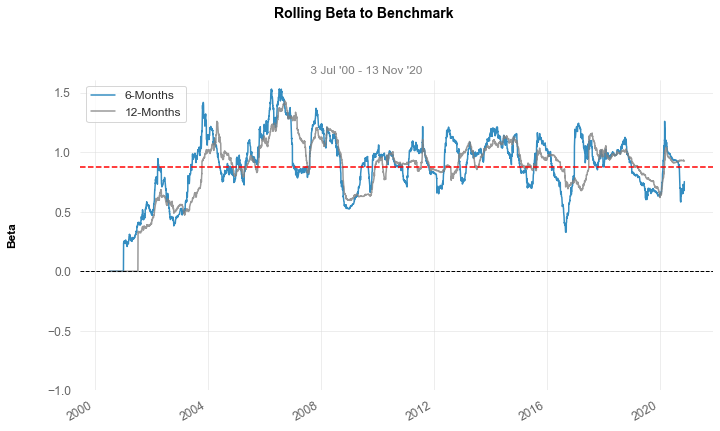

In [63]:
qs.plots.rolling_beta(estrategia, benchmark, figsize=(10,6))

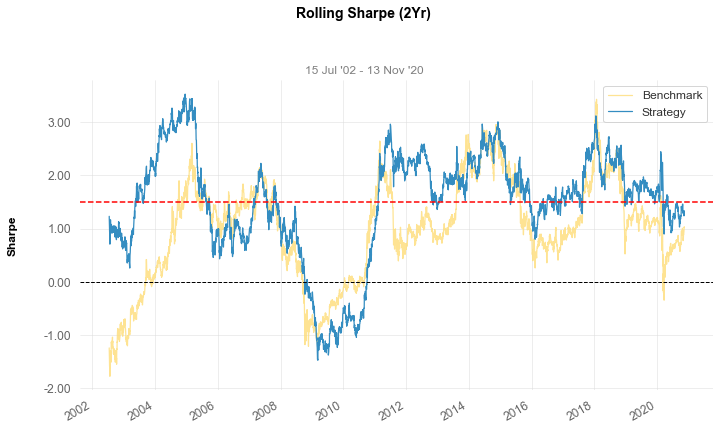

In [64]:
qs.plots.rolling_sharpe(estrategia, benchmark, figsize=(10,6), period=500, period_label='2Yr')

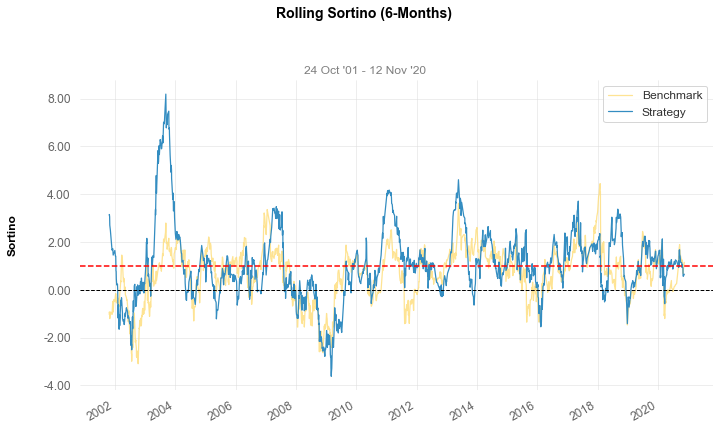

In [65]:
qs.plots.rolling_sortino(estrategia, benchmark, figsize=(10,6))

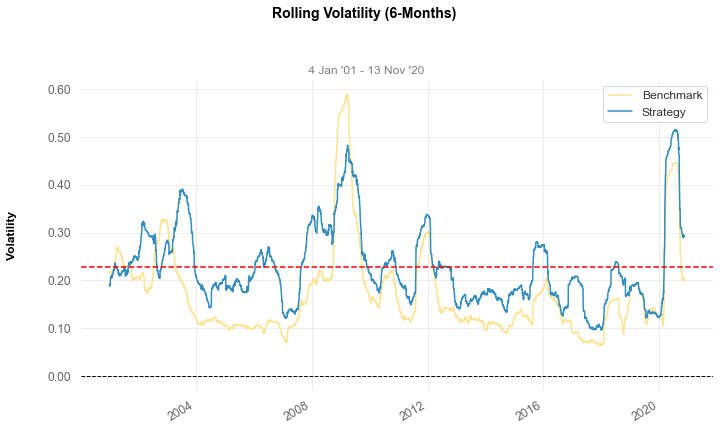

In [66]:
qs.plots.rolling_volatility(estrategia, benchmark, figsize=(10,6))

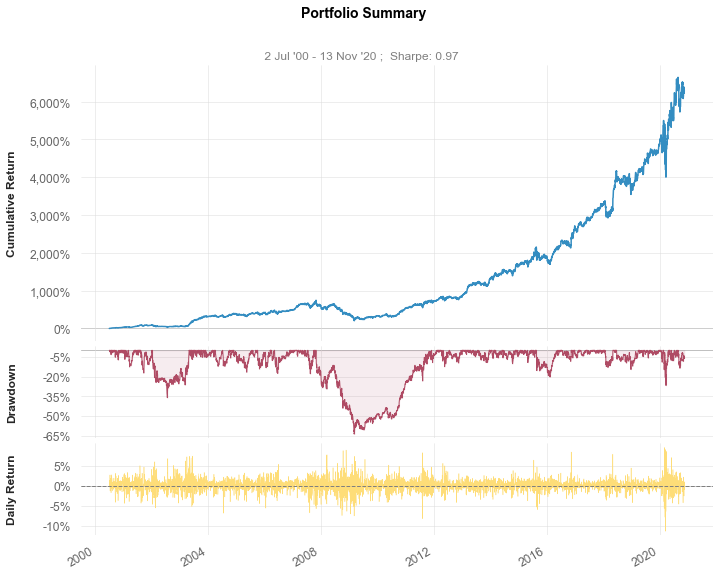

In [67]:
qs.plots.snapshot(estrategia)

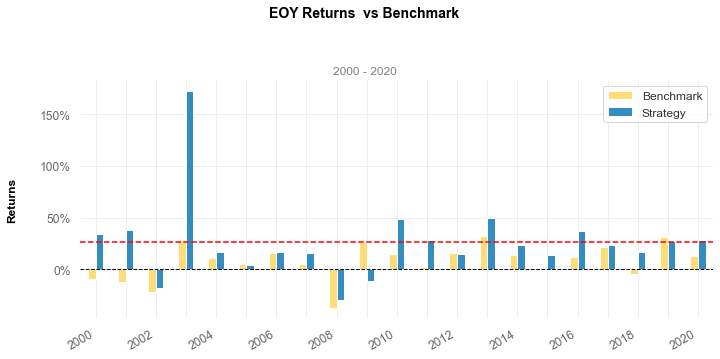

In [68]:
qs.plots.yearly_returns(estrategia, benchmark)